# Feature comparison between IDEAS, CP and SCIP features

In this notebook, we will compare feature sets generated using IDEAS, CellProfiler and SCIP. 

In [1]:
# %load common_.py
from common import *

In [2]:
import seaborn
import fcsparser
from sklearn.preprocessing import scale
from scipy.stats import pearsonr, spearmanr

## Loading the three feature sets

In [84]:
# cellprofiler features
df_cp = pandas.concat([
    pandas.read_csv(f"/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/cp_output/202111022047_4/{i}/BF_cells_on_grid.csv", skiprows=1)
    for i in range(1,5)
])
df_cp = df_cp.drop(columns=df_cp.filter(regex="\.1$"))

cp_meta_cols = ["ImageNumber", "ObjectNumber", "Number_Object_Number"]
cp_meta_cols.extend(df_cp.filter(regex="(FileName|PathName)").columns.values.tolist())
df_cp = df_cp.rename(columns=lambda col: f"meta_{col.lower()}" if col in cp_meta_cols else f"feat_{col.lower()}")
df_cp = df_cp[~df_cp["meta_pathname_1"].isna()]

groups = df_cp["meta_pathname_1"].map(lambda p: re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", Path(p).name).groupdict()).tolist()
df_cp["meta_group"] = list(map(lambda a: int(a["group"]), groups))
df_cp["meta_type"] = list(map(lambda a: a["type"], groups))
df_cp["meta_replicate"] = list(map(lambda a: int(a["replicate"]), groups))

df_cp = df_cp.drop(columns=df_cp.filter(regex="(filemame|pathname)").columns)

df_cp.shape

(11600, 255)

In [85]:
df_cp = df_cp[~df_cp["feat_areashape_area"].isna()]
df_cp.shape

(10222, 255)

In [86]:
df_scip = pq.read_table("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/scip/202111091707_no_export_no_rescale/features.parquet").to_pandas()
df_scip["meta_object_number"] = df_scip.index.map(lambda a: a.split("_")[1]).astype(int)
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip.shape

(76063, 1076)

In [87]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(74506, 1076)

In [88]:
# ideas features
tmp = []
for p in Path("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/ideas/202111031041_Inf_R1/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)
df_ideas = df_ideas[df_ideas["group"] != 3]

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(10297, 159)

## Are there NaN values, in what features and rows do they occur?

In [89]:
nan_cp = df_cp.filter(regex="feat").columns[df_cp.filter(regex="feat").isna().any()]
nan_cp

Index(['feat_location_center_x', 'feat_location_center_y'], dtype='object')

In [90]:
nan_scip = df_scip.filter(regex="feat").columns[df_scip.filter(regex="feat").isna().any()]
nan_scip

Index(['feat_inertia_tensor_0', 'feat_inertia_tensor_eigvals_0',
       'feat_moments_hu_0', 'feat_eccentricity_1', 'feat_euler_number_1',
       'feat_inertia_tensor_1', 'feat_inertia_tensor_eigvals_1',
       'feat_moments_hu_1', 'feat_orientation_1', 'feat_solidity_1',
       ...
       'feat_bgcorr_hog_28_6', 'feat_bgcorr_hog_29_6', 'feat_bgcorr_hog_30_6',
       'feat_bgcorr_hog_31_6', 'feat_bgcorr_hog_32_6', 'feat_bgcorr_hog_33_6',
       'feat_bgcorr_hog_34_6', 'feat_bgcorr_hog_35_6',
       'feat_shannon_entropy_6', 'feat_bgcorr_shannon_entropy_6'],
      dtype='object', length=647)

In [91]:
nan_ideas = df_ideas.filter(regex="feat").columns[df_ideas.filter(regex="feat").isna().any()]
nan_ideas

Index([], dtype='object')

In [92]:
df_cp = df_cp.drop(columns=nan_cp)
df_cp.shape

(10222, 253)

In [93]:
df_scip = df_scip.drop(columns=nan_scip)
df_scip.shape

(74506, 429)

## Are there any zero-variance or NaN-variance features?

In [94]:
zero_var_scip = df_scip.filter(regex="feat.*").loc[:, df_scip.filter(regex="feat.*").var(axis=0) == 0].columns
zero_var_scip

Index(['feat_edge_min_0', 'feat_bgcorr_edge_min_0'], dtype='object')

In [95]:
zero_var_cp = df_cp.filter(regex="feat.*").loc[:, df_cp.filter(regex="feat.*").var(axis=0) == 0].columns
zero_var_cp

Index(['feat_areashape_eulernumber', 'feat_location_centermassintensity_z_r1',
       'feat_location_maxintensity_z_r1',
       'feat_location_centermassintensity_z_r3',
       'feat_location_centermassintensity_z_r7',
       'feat_location_maxintensity_z_r3', 'feat_location_maxintensity_z_r7'],
      dtype='object')

In [96]:
zero_var_ideas = df_ideas.filter(regex="feat.*").loc[:, df_ideas.filter(regex="feat.*").var(axis=0) == 0].columns
zero_var_ideas

Index([], dtype='object')

In [97]:
df_scip = df_scip.drop(columns=zero_var_scip)
df_scip.shape

(74506, 427)

In [98]:
df_cp = df_cp.drop(columns=zero_var_cp)
df_cp.shape

(10222, 246)

In [99]:
nan_var_scip = df_scip.filter(regex="feat.*").columns[df_scip.filter(regex="feat.*").var(axis=0).isna()]
nan_var_scip

Index(['feat_edge_diff_entropy_0', 'feat_bgcorr_edge_diff_entropy_0',
       'feat_edge_diff_entropy_1', 'feat_bgcorr_edge_diff_entropy_1',
       'feat_edge_diff_entropy_2', 'feat_bgcorr_edge_diff_entropy_2',
       'feat_edge_diff_entropy_3', 'feat_bgcorr_edge_diff_entropy_3',
       'feat_edge_diff_entropy_4', 'feat_bgcorr_edge_diff_entropy_4',
       'feat_edge_diff_entropy_5', 'feat_bgcorr_edge_diff_entropy_5',
       'feat_edge_diff_entropy_6', 'feat_bgcorr_edge_diff_entropy_6'],
      dtype='object')

In [100]:
nan_var_cp = df_cp.filter(regex="feat.*").columns[df_cp.filter(regex="feat.*").var(axis=0).isna()]
nan_var_cp

Index([], dtype='object')

In [101]:
nan_var_ideas = df_ideas.filter(regex="feat.*").columns[df_ideas.filter(regex="feat.*").var(axis=0).isna()]
nan_var_ideas

Index([], dtype='object')

In [102]:
df_scip = df_scip.drop(columns=nan_var_scip)
df_scip.shape

(74506, 413)

# Comparing features between IDEAS and SCIP

In [103]:
df_scip = df_scip.set_index(["meta_object_number", "meta_replicate", "meta_group"])

In [104]:
df_ideas = df_ideas.set_index(["meta_object_number", "meta_replicate", "meta_group"])

In [105]:
df_joined = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.drop(columns="meta_type").rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_replicate", "meta_group"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)

In [106]:
def compare_features(x1, x2):
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    sorted_index = df_joined[x1].sort_values().index
    z1 = df_joined[x1].values
    z2 = df_joined[x2].values

    sorted_index = numpy.argsort(z1)
    z = numpy.polyfit(z1, z2, 1)
    y_hat = numpy.poly1d(z)(z1[sorted_index])
    ax.plot(z1[sorted_index], y_hat, "--", lw=0.5, color="grey")
    ax.scatter(z1[sorted_index], z2[sorted_index], s=0.5, alpha=0.5, edgecolors="none")
    ax.set_title(r'pearson = %.4f, spearman = %.4f' % (pearsonr(z1,z2)[0], spearmanr(z1,z2)[0]))

### Texture

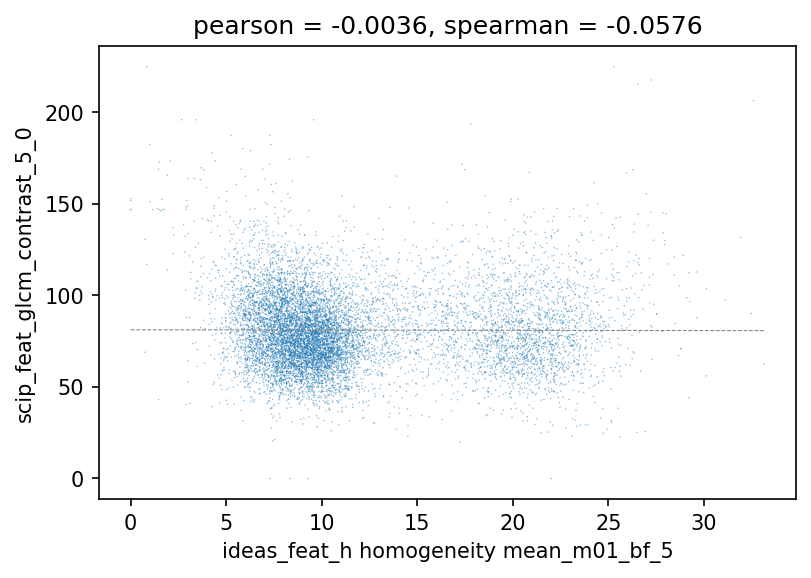

In [107]:
compare_features("ideas_feat_h homogeneity mean_m01_bf_5", "scip_feat_glcm_contrast_5_0")

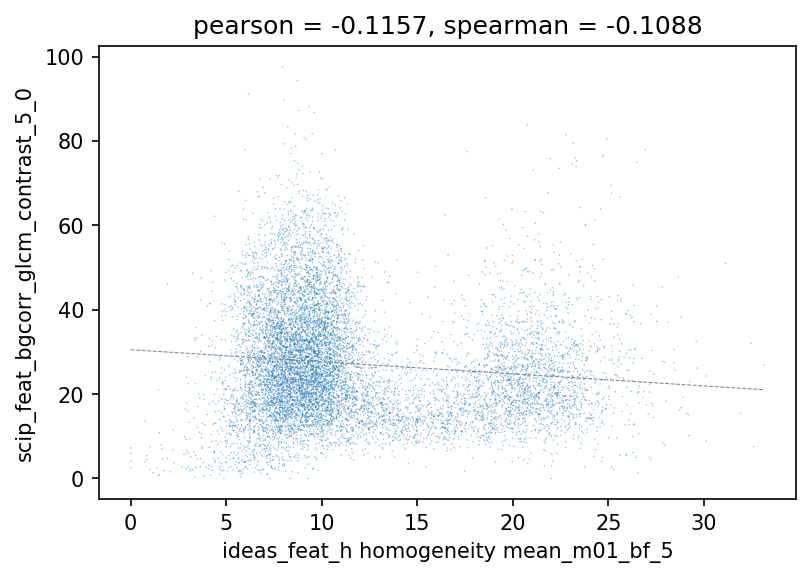

In [108]:
compare_features("ideas_feat_h homogeneity mean_m01_bf_5", "scip_feat_bgcorr_glcm_contrast_5_0")

In [109]:
df_joined[df_joined["ideas_feat_h homogeneity mean_m01_bf_5"] > 20]["scip_meta_1"].iloc[0]

'/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Ctrl_T0_R1/862_Ch1.ome.tif'

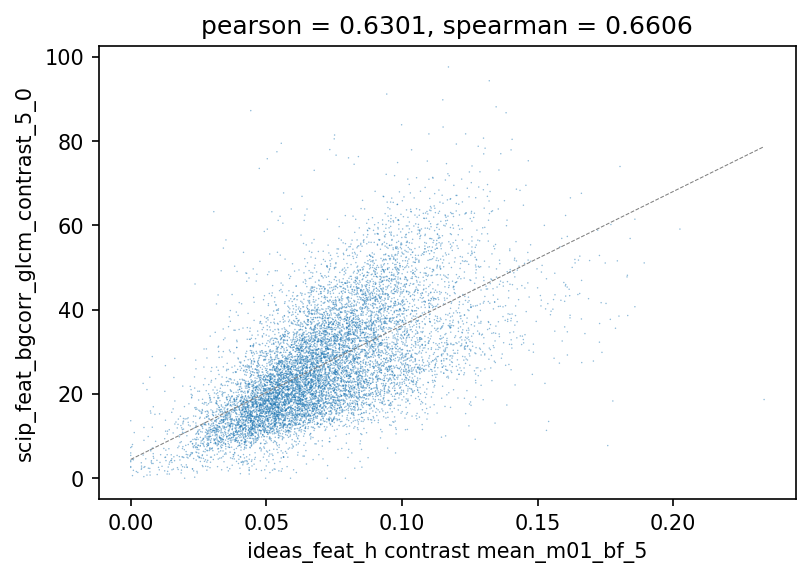

In [110]:
compare_features("ideas_feat_h contrast mean_m01_bf_5", "scip_feat_bgcorr_glcm_contrast_5_0")

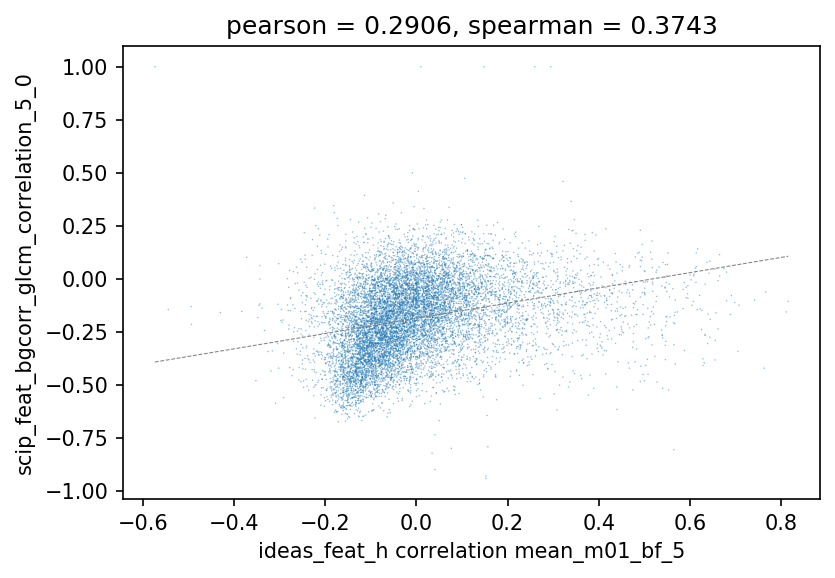

In [111]:
compare_features("ideas_feat_h correlation mean_m01_bf_5", "scip_feat_bgcorr_glcm_correlation_5_0")

### Shape

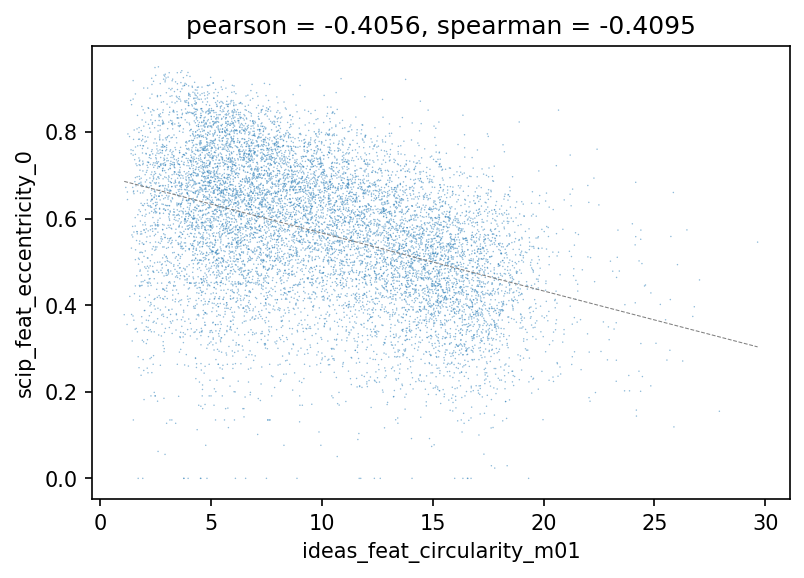

In [112]:
compare_features("ideas_feat_circularity_m01", "scip_feat_eccentricity_0")

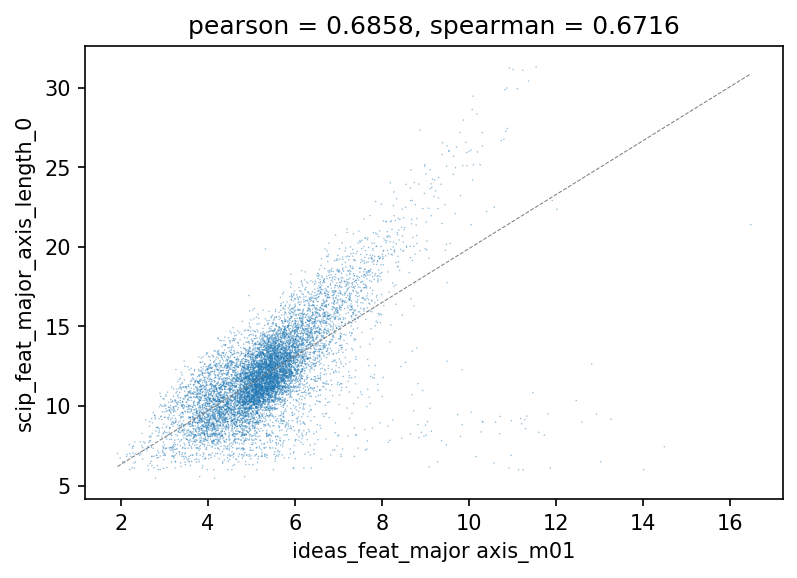

In [33]:
compare_features("ideas_feat_major axis_m01", "scip_feat_major_axis_length_0")

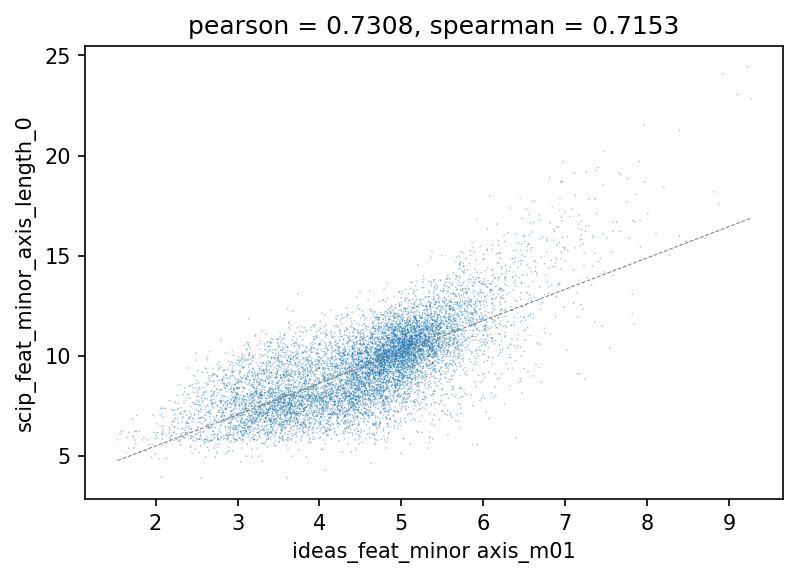

In [34]:
compare_features("ideas_feat_minor axis_m01", "scip_feat_minor_axis_length_0")

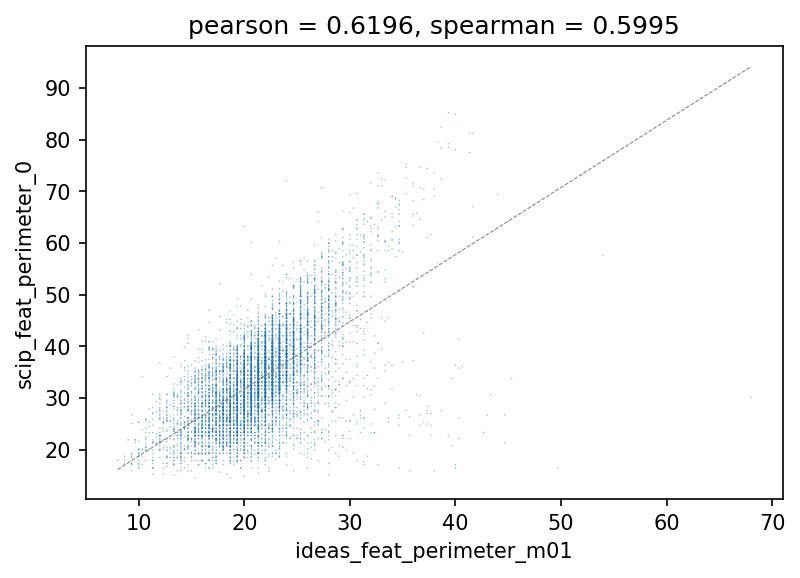

In [35]:
compare_features("ideas_feat_perimeter_m01", "scip_feat_perimeter_0")

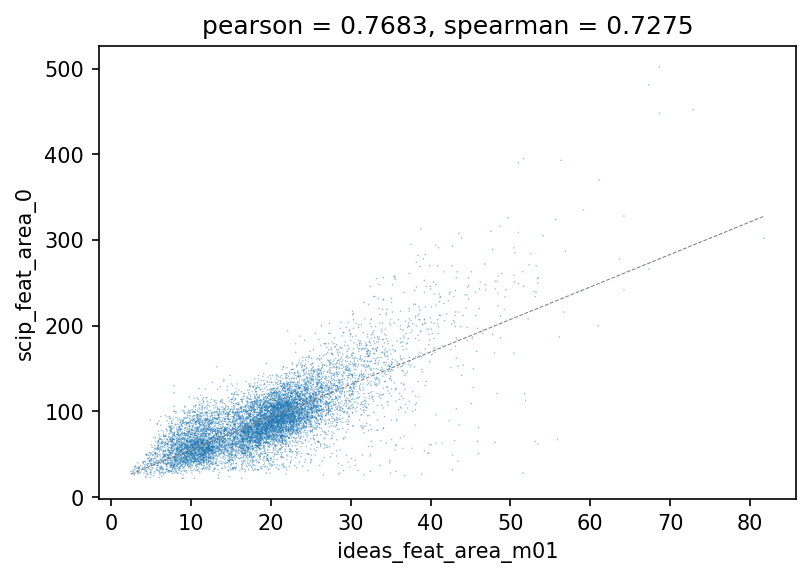

In [36]:
compare_features("ideas_feat_area_m01", "scip_feat_area_0")

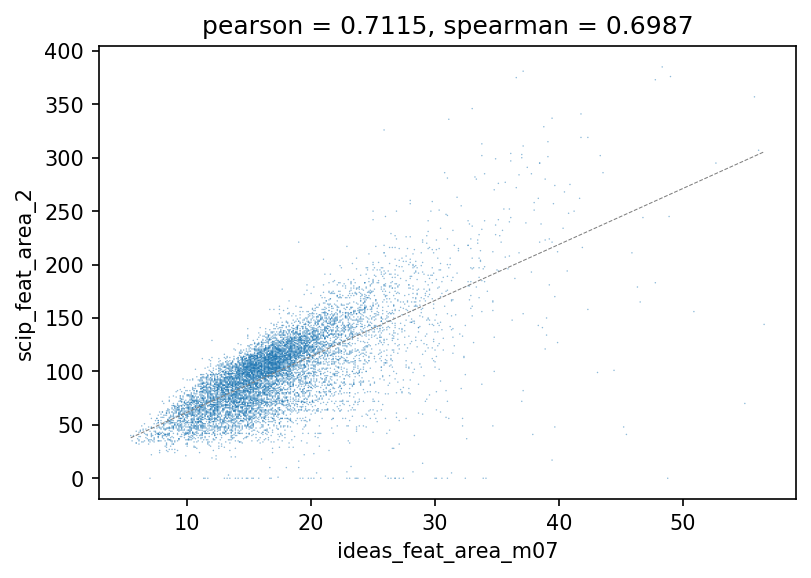

In [37]:
compare_features("ideas_feat_area_m07", "scip_feat_area_2")

### Intensity features

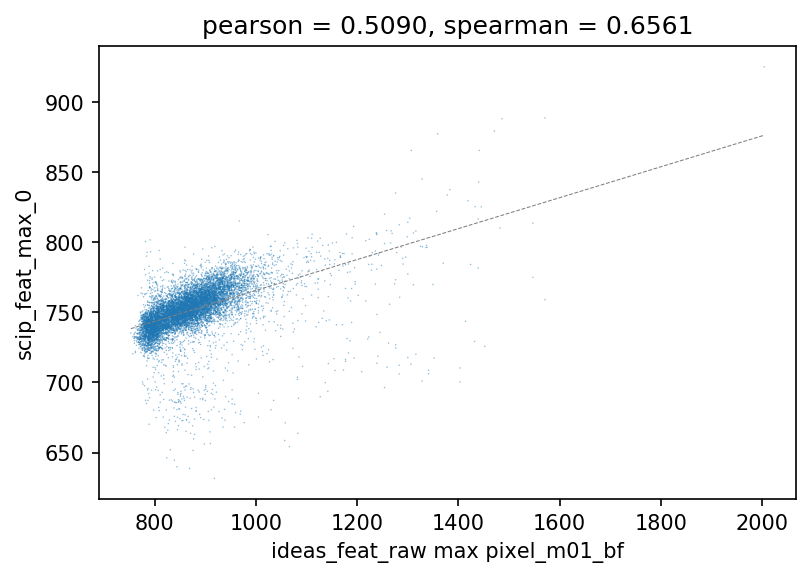

In [113]:
compare_features("ideas_feat_raw max pixel_m01_bf", "scip_feat_max_0")

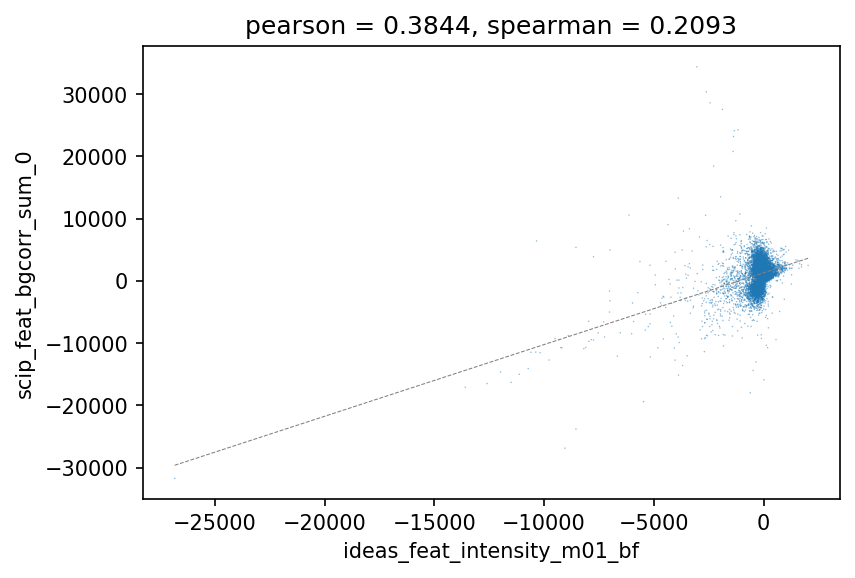

In [114]:
compare_features("ideas_feat_intensity_m01_bf", "scip_feat_bgcorr_sum_0")

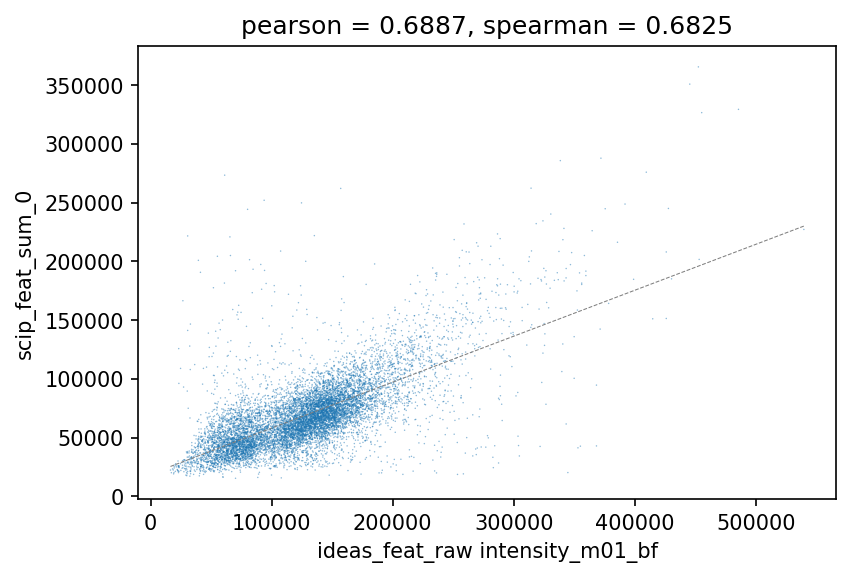

In [115]:
compare_features("ideas_feat_raw intensity_m01_bf", "scip_feat_sum_0")

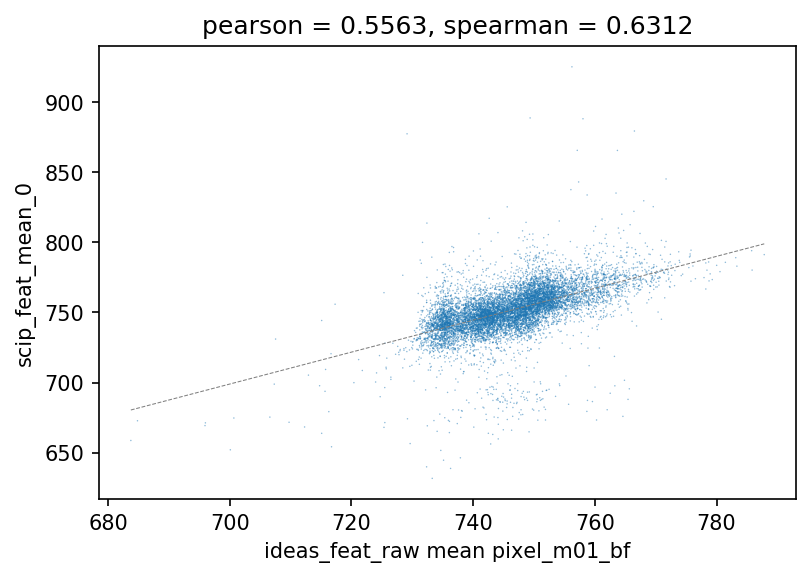

In [116]:
compare_features("ideas_feat_raw mean pixel_m01_bf", "scip_feat_mean_0")

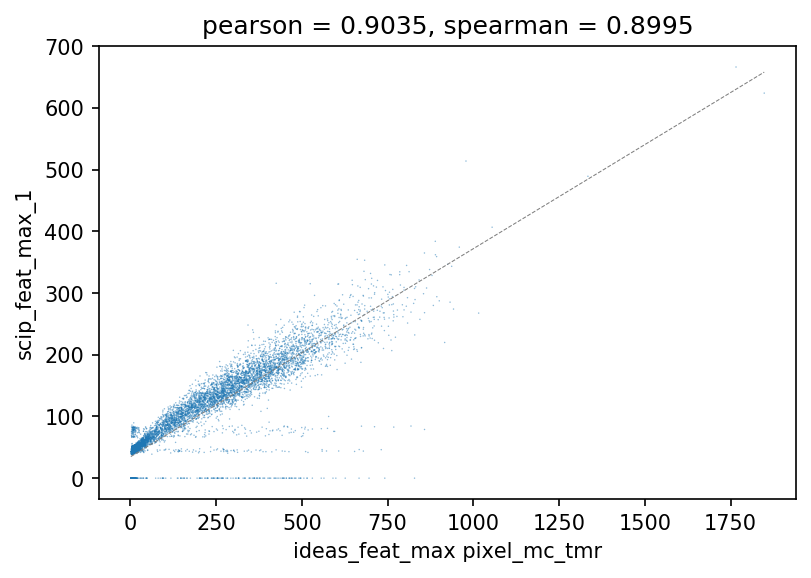

In [117]:
compare_features("ideas_feat_max pixel_mc_tmr", "scip_feat_max_1")

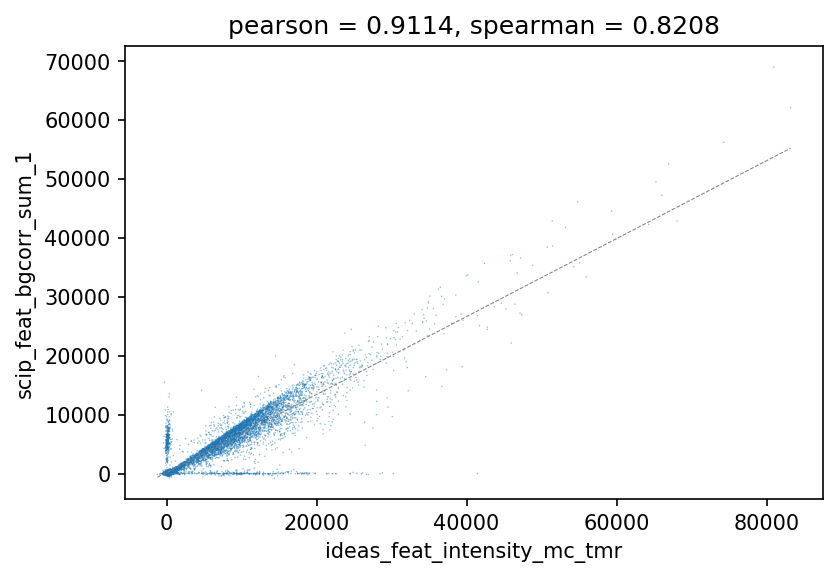

In [118]:
compare_features("ideas_feat_intensity_mc_tmr", "scip_feat_bgcorr_sum_1")